# CapHand: Detecting Handedness of Interactions

### Introduction

Touchscreens are becoming omnipresent, and are now one of the most common ways to interact with a smart device. Although ubiquitous, the vocabulary of touch inputs is currently limited. The goal of our project is to expand the touch vocabulary by sensing the handedness of an interaction, and ultimately provide a better user experience. We propose CapHand, a novel sensing technique to determine which hand is being used to touch a mobile device such as a tablet or phone. We will use CapCam [1], a combination of raw capacitance values and a camera that enables accurate and enhanced spatial tracking to gather data about the position, angle and orientation of an interaction. We will use this spatial information of the interaction to train a classifier that will allow us to accurately determine the handedness of an interaction.  While this work has several utilities, for the purpose of this class we will demonstrate one application that showcases the strengths of our work. We will present an alternative to Carpacio [2], that uses custom hardware to determine if the driver or passenger is interacting with the touchscreen. The intuition behind our chosen application is that due to the placement of driver/passenger, the driver is likely to use their right hand to interact, whereas the passenger is likely to use their left hand. Thus, using our novel sensing technique, we can replicate Carpacio’s work without custom hardware.


### Raw Capacitance Value (Getting Sensor Data from Tablet)

We modified the kernel of a Nexus 5 tablet to read the individual capacitance values from each capacitor present on a touchscreen as shown in in Figure 1. These raw capacitance values are generated when an object (<i>e.g., </i> human finger) comes closer to the touchscreen. These capacitance values change based on how far (or how much pressure the finger exerts when touching the screen). The stronger the touch, the higher the value. 

### Data Collection from Android application

We wrote an android application to log the values of each of the capacitors when a person touches the screen. Our application logs values obtained from a grid of 6x6 capacitors. However, upon data collection, we noticed that the corner values were always zero (i.e. the capacitors were not registering any touch), so we reduced the grid to collect data from a 5x6 grid instead. The following sample code shows our data logging function in Android. 

#### NOTE: We asked Zico for permission for not sharing the modifief Kernel and Android code, due to them being a part of active research in our lab. 


In [ ]:
### DO NOT RUN THIS CODE. THIS IS ANDROID CODE TO SHOW HOW WE LOGGED THE DATA.        
    
    
        if (touch.id >= 0){   #checks if a touch is registered (not simply a hover)
                starty = (touch.y/(int)pxh)  - 3;  #sets the grid positions
                endy = (touch.y/(int)pxh) + 3;
                startx = (touch.x/(int)pxw) - 3;
                endx = (touch.x/(int)pxw) + 3;

                if (Environment.MEDIA_MOUNTED.equals(state)) {  #writing it to external storage

                    try {

                        file = new File(Environment.getExternalStoragePublicDirectory(Environment.DIRECTORY_PICTURES), filePath);
                        writer = new FileWriter(file, true   );
                        long currentTime = Calendar.getInstance().getTimeInMillis();
                        writer.write(Long.toString(currentTime) + ";");  #adding timestamp to each recorded value

                    } catch (IOException e) {
                        e.printStackTrace();
                        Log.d("datac", "error with file writing");
                    }
                }else {
                    Log.d("datac", "no external storage found");
                }
            }


        for(int y = starty; y < endy; y++) {      
                for(int x = startx; x < endx; x++) {

                    int val = capImage[y * capw + x];  #our function (not shown) to read the capacitance values
                    
                    if(val < 0) {    #changing the value on screen to show feedback to user that they touched.
                        int color = 255 - Math.max(0, Math.min(-val * 8, 255));
                        capPaint.setARGB(255, color, 255, 255);
                        capValTextPaint.setARGB(255, 0, 0, 0);
                        
                    } else if(val >= 0) {
                        int color = 255 - Math.max(0, Math.min(val, 255));
                        capPaint.setARGB(255, color, color, color);
                        int tcolor = (color < 127) ? 255 : 0;
                        capValTextPaint.setARGB(255, tcolor, tcolor, tcolor);
                        
                    } else {
                        continue;
                    }

                    canvas.drawRect(x * pxw, y * pxh, (x + 1) * pxw, (y + 1) * pxh, capPaint);
                    canvas.drawText(Integer.toString(val), x * pxw, (y + 1) * pxh, capValTextPaint);

                    if (touch.id >=0){
                        try {
                            writer.write(Integer.toString(val) + ";");  #if touch was detected, we record values for each of those grid
                        }catch (Exception e){
                            e.printStackTrace();
                            Log.d("datac", "error with file writing");
                        }
                    }
                    
                }
            }

            try {
                if (touch.id >=0) {
                    writer.write("\n");
                    writer.close();
                }
                
            } catch (IOException e) {
                e.printStackTrace();
            }
        }

        if(touch.id >= 0) {
            canvas.save();
            canvas.translate(touch.x, touch.y);

            #The following lines just draw an oval on the screen showing the touch point to give feedback to the user.
            
            float r = 3;
            touchPaint.setStyle(Paint.Style.FILL);
            canvas.drawOval(-r, -r, r, r, touchPaint);

            touchPaint.setStyle(Paint.Style.STROKE);
            canvas.rotate(touch.orientation);
            if(touch.pressure > 0) {
                float pr = touch.pressure * 20;
                canvas.drawOval(-pr, -pr, pr, pr, touchPaint);
            }
            /* TODO: orientation, distance */
            if(touch.touch_major > 0 && touch.touch_minor > 0) {
                float rx = touch.touch_major * 20;
                float ry = touch.touch_minor * 20;
                canvas.drawOval(-rx, -ry, rx, ry, touchPaint);
            }
            if(touch.width_major > 0 && touch.width_minor > 0) {
                float rx = touch.width_major * 20;
                float ry = touch.width_minor * 20;
                canvas.drawOval(-rx, -ry, rx, ry, touchPaint);
            }

            canvas.restore();
        }

### Data Collection from Users

We collected data from 5 people. 4 people performed 1 session each, and 1 person recorded 2 sessions at different times of the day. Each person touched the screen at random locations (chosen by the user) for 5 mins using their left index finger, and 5 mins using their right index finger.

In [1]:
import glob
from sklearn import svm
import random
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

C:\Users\Apoorva\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Cleaning & Processing

We take the raw dump of the sensor data (semicolon delimeted), and convert it to features using the following function. The function reads the file, extracts each capacitor value, normalizes each value between 0-255, and stores it as a feature.

We have another function remove_bad_points() that removes any line that didn't capture all 30 capacitor values. 

In [2]:
def features_from_file(fname):

    total_features = []
    
    f = open(fname, 'r')
    lines = f.readlines()
    f.close()
    
    for line in lines:
        data = line.split(';')
        
        timestamp = data[0]
        features = data[1:31]
        
        
        
        for index in range(len(features)):
            features[index] = int(features[index])
            
            features[index] = 255 - max(0, min(features[index], 255))
                
        total_features.append(features)

    return total_features
        

def remove_bad_data_points(features):

    remove_points = []

    for i in features:
        if len(i) != 30:
            remove_points.append(features.index(i))

    remove_points.sort(reverse=True)        
        
    for i in remove_points:
        features.pop(i)
    
    return features

We use the glob library in python that reads all files in a directory based on our wild card search. We balance the number of examples for left touches and right touches in the training data, but not in the test data.

In [3]:
def read_train_files(folder_path):

    left = glob.glob(folder_path + 'left*.txt')
    right = glob.glob(folder_path + 'right*.txt')


    total_left_features = []
    total_right_features = []


    for i in left:
        total_left_features = total_left_features + features_from_file(i)

    for i in right:
        total_right_features = total_right_features + features_from_file(i)

        
    
    total_left_features = remove_bad_data_points(total_left_features)
    total_right_features = remove_bad_data_points(total_right_features)


    training_data = []

    if len(total_left_features) > len(total_right_features):
        training_left = random.sample(total_left_features, len(total_right_features))
        training_data = training_left + total_right_features

    if len(total_left_features) < len(total_right_features):
        training_right = random.sample(total_right_features, len(total_left_features))
        training_data = total_left_features + training_right

    N_inst = int(len(training_data) / 2)
    training_labels = []

    for i in range(N_inst):
        training_labels.append(0)

    for i in range(N_inst):
        training_labels.append(1)
        
    return training_data, training_labels

def read_test_files(folder_path):

    left = glob.glob(folder_path + 'left*.txt')
    right = glob.glob(folder_path + 'right*.txt')
    
    test_features = []
    test_labels = []

    total_left_features = []
    total_right_features = []
    
    for i in left:
        total_left_features = total_left_features + features_from_file(i)

    for i in right:
        total_right_features = total_right_features + features_from_file(i)
    
    total_left_features = remove_bad_data_points(total_left_features)
    total_right_features = remove_bad_data_points(total_right_features)
    

    testing_data = total_left_features + total_right_features

    for i in range(len(total_left_features)):
        test_labels.append(0)

    for i in range(len(total_right_features)):
        test_labels.append(1)


    return testing_data, test_labels

### Analysis

We look at three different cases using our data: 
1. User Independent Model
2. User Dependent Model
3. Session Independent Model

Before building any of the models, we visualize the data to better understand any visual distinction between the left touches and right touches,if any. 

### Reading the data (User Independence)

For user independence, we kept data from 4 users in one folder, and the data of one person (not used in training) separately. The data format is such that the rows represnet a single touch instance where the features are capacitance values from 30 capacitors.

In [4]:
training_data, training_labels = read_train_files('./user-independent/')
testing_data, testing_labels = read_test_files('./user-independent/test/')

training_data = np.array(training_data)
testing_data = np.array(testing_data)

print("Shape of training data: ", training_data.shape)
print("Shape of testing data:  ", testing_data.shape)

Shape of training data:  (4202, 30)
Shape of testing data:   (947, 30)


(5149, 30)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5149 samples in 0.012s...
[t-SNE] Computed neighbors for 5149 samples in 0.863s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5149
[t-SNE] Computed conditional probabilities for sample 2000 / 5149
[t-SNE] Computed conditional probabilities for sample 3000 / 5149
[t-SNE] Computed conditional probabilities for sample 4000 / 5149
[t-SNE] Computed conditional probabilities for sample 5000 / 5149
[t-SNE] Computed conditional probabilities for sample 5149 / 5149
[t-SNE] Mean sigma: 14.724906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.266098
[t-SNE] Error after 1000 iterations: 1.388330


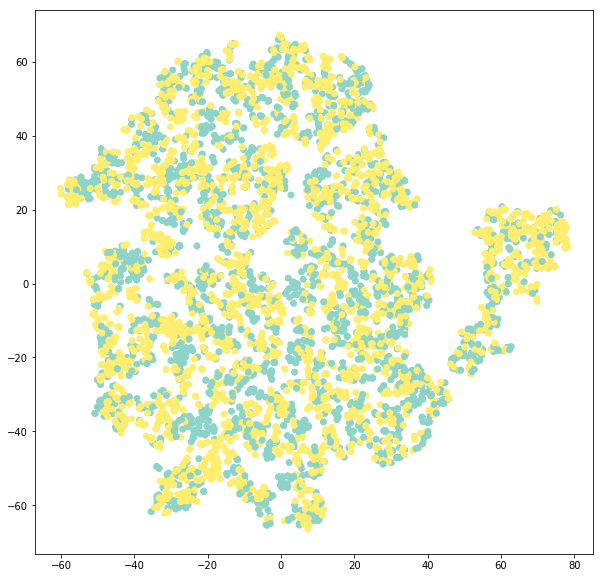

In [5]:
visual_data = np.append(training_data,testing_data,axis=0)
print(visual_data.shape)

visual_labels = training_labels + testing_labels

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne2d = tsne.fit_transform(visual_data)
plt.figure(figsize=(10,10))
plt.scatter(tsne2d[:, 0], tsne2d[:, 1], c=visual_labels, cmap='Set3')
#plt.legend()
plt.show()


The figure above is the 2D visualization of the whole data. The data dimensionality was reduced using TSNE which is the current best algorithm for dimensionality reduction. We can see that both the left and right touches overlap, and do not form distinct clusters, so it is likely that a linear classifier is not suitable for our purposes.

### Histograms of different capacitance values from different capacitors

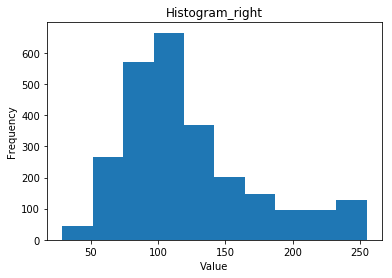

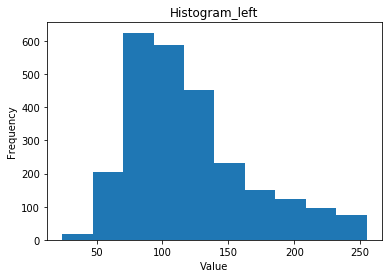

In [7]:
right_labels = np.argwhere(visual_labels)
plt.hist(visual_data[right_labels,15])
plt.title("Histogram_right")
plt.xlabel("Value")
#plt.xticks(np.unique(visual_data))
plt.ylabel("Frequency")
plt.show()
#print(list(right_labels))
all_indices = [x for x in range(visual_data.shape[0])]
left_labels = list(set(all_indices) - set([x[0] for x in right_labels]))

plt.hist(visual_data[np.array(left_labels),15])
plt.title("Histogram_left")
plt.xlabel("Value")
#plt.xticks(np.unique(visual_data))
plt.ylabel("Frequency")
plt.show()


We demonstrate the histograms of values from capacitor 15 for left and right touches. While the values are centered in the same range, there are differences between those values for a machine learning algorithm to understand the difference.


## User Independent Model

We build a model with data from 4 people, and test it on the 5th. Unfortunately, we didn't achieve high accuracy for user independence. This means that the data doesn't generalizes over different people, and capacitance cannot be used to distinguish between user independent touches individually. We tried several classifiers, however a simple deep learning model gave the best results. Our code is as shown below. 

In [6]:

def smallify():
    model = Sequential()
    model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=smallify, epochs=200, batch_size=7, verbose=0)))
pipeline = Pipeline(estimators)


pipeline.fit(training_data, training_labels)
y_pred = pipeline.predict(testing_data)

C:\Users\Apoorva\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
accuracy = accuracy_score(testing_labels, y_pred)
print(accuracy)

0.5723336853220697


As we can see, it is only slightly better than chance for a user independent model. Therefore, our approach is not generalizable and we move to a user dependent model.

## User Dependent Model

Now we focus on a user dependent model. Here, we train the classifier with data from all 5 participants and used cross validation (test/train split) on that data to evaluate our model. A high accuracy on this model demonstrates that our model is generalizable, but requires boosting. In a real world application, the boosting will help create a base model to improve generalizability, improve training time (improves convergence). The convergence will be faster because we can simply train the new user using boosted model (e.g. warm start on random forest or fine tuning for neural networks). 

We now show our pipeline for a user dependent model. 

In [8]:
training_data, training_labels = read_train_files('./')

We first visualize our data akin to what we did while testing for a user independent model. 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5128 samples in 0.021s...
[t-SNE] Computed neighbors for 5128 samples in 0.984s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5128
[t-SNE] Computed conditional probabilities for sample 2000 / 5128
[t-SNE] Computed conditional probabilities for sample 3000 / 5128
[t-SNE] Computed conditional probabilities for sample 4000 / 5128
[t-SNE] Computed conditional probabilities for sample 5000 / 5128
[t-SNE] Computed conditional probabilities for sample 5128 / 5128
[t-SNE] Mean sigma: 14.884618
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.081017
[t-SNE] Error after 1000 iterations: 1.389710


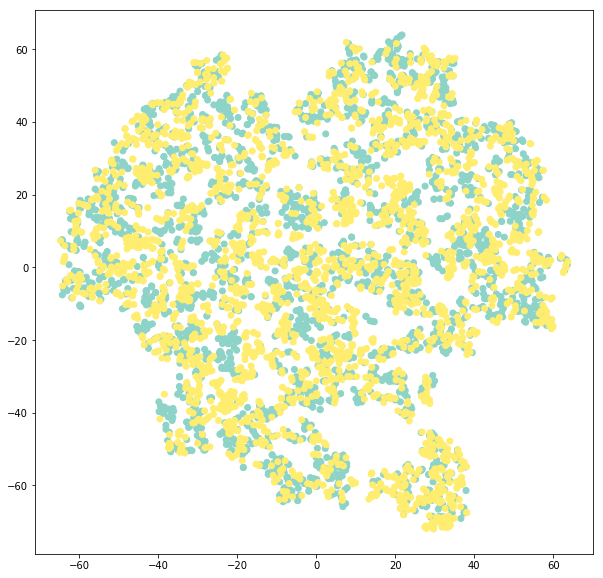

In [6]:
# visual_data = np.append(training_data,testing_data,axis=0)
# print(visual_data.shape)

# visual_labels = training_labels + testing_labels

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne2d = tsne.fit_transform(training_data)
plt.figure(figsize=(10,10))
plt.scatter(tsne2d[:, 0], tsne2d[:, 1], c=training_labels, cmap='Set3')
#plt.legend()
plt.show()


The figure above is the 2D visualization of the user dependent data. The data dimensionality was reduced using TSNE which is the current best algorithm for dimensionality reduction. We can see that both the left and right touches overlap, and do not form distinct clusters, so it is likely that again a linear classifier is not suitable for our purposes.

### Histograms of different capacitance values from different capacitors

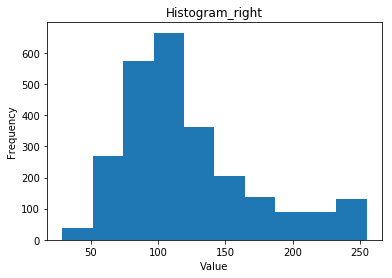

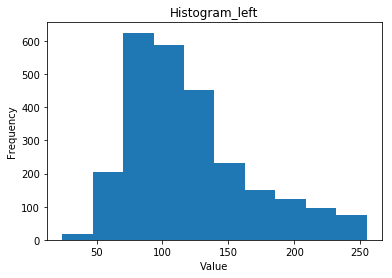

In [9]:
visual_data = np.array(training_data)
right_labels = np.argwhere(training_labels)
plt.hist(visual_data[right_labels,15])
plt.title("Histogram_right")
plt.xlabel("Value")
#plt.xticks(np.unique(visual_data))
plt.ylabel("Frequency")
plt.show()
#print(list(right_labels))
all_indices = [x for x in range(visual_data.shape[0])]
left_labels = list(set(all_indices) - set([x[0] for x in right_labels]))

plt.hist(visual_data[np.array(left_labels),15])
plt.title("Histogram_left")
plt.xlabel("Value")
#plt.xticks(np.unique(visual_data))
plt.ylabel("Frequency")
plt.show()

We demonstrate the histograms of values from capacitor 15 for left and right touches. Again we see that while the values are centered in the same range, there are differences between those values for a machine learning algorithm to understand the difference.

### Modelling using Machine Learning

 We tried a bunch of classifiers (shown below), and determined that Random Forest gives us the best accuracy. Cross validation accuracy has been reported for all the classifiers, where we used 10 fold cross validation. We also tried feature selection (shown below), but we empirically determined that using all features in this case gave us the best results.
 
We used polynomial features to convert the existing features in a higher dimensional space. We empirically determined that a <b>third</b> degree polynomial feature resulted in the best accuracy. 

In [20]:
#list of classifiers we tried:

clf = svm.SVC(decision_function_shape='ovr')
clf2 = MLPClassifier(solver='lbfgs', random_state = 700, learning_rate='adaptive', hidden_layer_sizes=(100,100, 100))
clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=700), random_state=700)

scores = cross_val_score(clf, training_data, training_labels, cv=10)
print("SVM accuracy: ", sum(scores)/10)

scores = cross_val_score(clf2, training_data, training_labels, cv=10)
print("MLP accuracy: ", sum(scores)/10)

scores = cross_val_score(clf3, training_data, training_labels, cv=10)
print("Adaboost accuracy: ", sum(scores)/10)

SVM accuracy:  0.5450419503891051
MLP accuracy:  0.718661843385214
Adaboost accuracy:  0.738943184581712


In [21]:
# Random Forest Classifier

clf = RandomForestClassifier(random_state=50)
scores = cross_val_score(clf, training_data, training_labels, cv=10)
print("RF accuracy: ", sum(scores)/10)


RF accuracy:  0.7997689688715953


### From the above accuracy scores we can see that Random forest with raw features works best. We additionally tried tuning hyper parameters of the above model but all of them did not show significant improvement in accuracy.

### Hyper parameter Tuning

We then used grid search to tune the hyperparameters. 

In [28]:
## Add code for grid search

parameters= {'max_depth':[i for i in range(80,90)], 'n_estimators':[i for i in range(10,15)], 'min_samples_leaf': [i for i in range(1,5)]}
rf = RandomForestClassifier()
clfgs = GridSearchCV(rf, parameters)
clfgs.fit(training_data, training_labels)
print(clfgs.cv_results_)

{'mean_fit_time': array([0.07340423, 0.07343006, 0.07923929, 0.08174674, 0.08764545,
       0.06080572, 0.06519866, 0.07296681, 0.08172766, 0.08588203,
       0.06141925, 0.06624834, 0.0728333 , 0.09090797, 0.08298262,
       0.06125824, 0.06430531, 0.06856171, 0.07684898, 0.08177551,
       0.08177408, 0.07409128, 0.07680035, 0.09040634, 0.09574763,
       0.06555772, 0.07407872, 0.07918437, 0.08096075, 0.08560101,
       0.06641761, 0.07348307, 0.07312981, 0.1017007 , 0.08337228,
       0.06578199, 0.06462471, 0.07525357, 0.08486986, 0.10154001,
       0.06858802, 0.07278927, 0.08989366, 0.10293134, 0.08835363,
       0.06775999, 0.06742485, 0.07376337, 0.08932583, 0.085428  ,
       0.06292939, 0.06771628, 0.08218749, 0.08673557, 0.08610956,
       0.07791885, 0.06843321, 0.07211534, 0.07494124, 0.08248329,
       0.06612905, 0.07298732, 0.07727925, 0.08322986, 0.08852156,
       0.06412141, 0.06969484, 0.08238109, 0.08836929, 0.08778056,
       0.0616583 , 0.06574074, 0.07161736, 0

In [30]:
print(clfgs.best_params_)

{'max_depth': 87, 'min_samples_leaf': 1, 'n_estimators': 14}


In [15]:
clf = RandomForestClassifier(random_state=50, max_depth=87, n_estimators=14)
scores = cross_val_score(clf, training_data, training_labels, cv=10)
print("RF accuracy: ", sum(scores)/10)

RF accuracy:  0.8093256018968871


### Feature Selection 

To improve the accuracy we tried doing feature selection. Different approaches were tried (show below in the two functions). However running random forest with all features resulted in the best accuracy.

In [13]:
def get_best_features(training_data, training_labels, no_of_features):


    temp = SelectKBest(k=no_of_features).fit(training_data, training_labels)

    X_new = temp.transform(training_data)
    best_cols = np.argsort(np.array(temp.scores_))[::-1]
    
    return best_cols[:no_of_features]

def recursive_feature_selection(X, y, estimator):
    selector = RFECV(estimator, step=1, cv=5)
    selector = selector.fit(X, y)
    
    return selector.support_

In [18]:

best_cols = recursive_feature_selection(training_data, training_labels, clf)
training_data = np.asarray(training_data)
scores = cross_val_score(clf, training_data[:,best_cols], training_labels, cv=10)
print("RF accuracy with recursive feature selection: ", sum(scores)/10)

RF accuracy with recursive feature selection:  0.8112886065175097


In [17]:
best_cols = get_best_features(training_data, training_labels,10)
training_data = np.asarray(training_data)
scores = cross_val_score(clf, training_data[:,best_cols], training_labels, cv=10)
print("RF accuracy with selectK best feature selection: ", sum(scores)/10)

RF accuracy with selectK best feature selection:  0.691564323929961


### Higher Dimensional Features

We also tried to look at polynomial features and a 3rd degree poly showed the best results.

In [22]:
poly = PolynomialFeatures(3)
X_new = poly.fit_transform(training_data)

scores = cross_val_score(clf, X_new, training_labels, cv=10)
print("RF accuracy: ", sum(scores)/10)

f1score = cross_val_score(clf, X_new, training_labels, cv=10, scoring='f1')
print("RF flscore: ", sum(f1score)/10)

RF accuracy:  0.9317073170731709
RF flscore:  0.9287061317962738


### Neural Network

We also ran a neural network to determine a deep learning method for a user dependent model: 

In [9]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=smallify, epochs=200, batch_size=7, verbose=0)))
pipeline = Pipeline(estimators)


pipeline.fit(training_data, training_labels)
y_pred = pipeline.predict(testing_data)

accuracy = accuracy_score(testing_labels, y_pred)
print(accuracy)

0.8901795142555439


C:\Users\Apoorva\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Session Independence


We also wanted to determine if our model can be session independent. We have 1 participant who performed 2 sessions at different times. So, we trained our data on session 1, and tested on data 2 to determine session independence. We show our results below. We use the same parameters determined in the user dependent model, to show how session independence works. 

In [19]:
training_data, training_labels = read_train_files('./session/')
testing_data, testing_labels = read_test_files('./session/test/')

In [21]:


clf = RandomForestClassifier(random_state=50, max_depth=87, n_estimators=14)

clf.fit(training_data, training_labels)

y_pred = clf.predict(testing_data)
accuracy = accuracy_score(testing_labels, y_pred)
print("Session Independence Accuracy",accuracy)

Session Independence Accuracy 0.9080962800875274


As can be seen, we achieved session independence which means that a model once trained on a user can then be used again at a later stage i.e. the training only needs to occur once.

## Conclusion

We present CapHand: a system to detect which hand was used to touch a mobile device. We modified an Android tablet to obtain the raw capacitance value for each capacitor. When a point on the screen is touched, we record the sensor data from each individual capacitor and use a machine learning model to determine which hand is touching the screen. 

We determined that for a user dependent model, a random classifier provides us a balance between training speed, interpretability and accuracy. The final random forest classifier with polynomial features had both a good accuracy as well as f1score. A deep learning model in our case is suprisingly not that accurate (by ~10%), is slow and less interpretable. We also achieved session independence which shows that we can buld a model once per user, and use it a later stage. Thus a user doesn't need to recalibrate a product every time they interact with a device. 

We were not able to build a successful user independent model. This can be attributed to different people touching the screen differently (e.g. pressure, surface area and angle of touch).

Our system has several applications. When driving in a car, the entertainment screen is active when the passenger touches the device, but is disabled when the driver attempts to touch it.  Secondly, it expands the current possible interactions. When an article is touched with the left hand, it opens up the article. However, when touched with the right hand, it acts as a right click and opens up an option dialogue box. We demonstrate these applications in the project video. (https://youtu.be/4J1UM4Cs4e4)

By detecting the handedness of interactions, CapHand is able to leverage everyday sensor data and opens up a wide range of applications on touch devices. 

### Future Work

We postulate that we can still engineer a user independent model with more data and feature engineering. We strive to build a pre-trained model that can be remotely pushed to all touchscreen devices in the future via a simple software update.

### References

[1] Xiao, R., Hudson, S., & Harrison, C. (2016, November). CapCam:
Enabling Rapid, Ad-Hoc, Position-Tracked Interactions Between Devices.
In Proceedings of the 2016 ACM on Interactive Surfaces and Spaces (pp.
169-178). ACM.

[2] Wang, E. J., Garrison, J., Whitmire, E., Goel, M., & Patel, S.
(2017, October). Carpacio: Repurposing Capacitive Sensors to
Distinguish Driver and Passenger Touches on In-Vehicle Screens. In
Proceedings of the 30th Annual ACM Symposium on User Interface
Software and Technology (pp. 49-55). ACM.

[3] http://scikit-learn.org/stable/

[4] https://keras.io/